In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-06-09 
Git hash: 5d75a010c3a45348c61a4d9d358243b80eba07e5


In [93]:
# Imports and settings
from ncbi_remap.parser import parse_picardCollect_hist, parse_featureCounts_jcounts, parse_featureCounts_counts
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 999

In [3]:
# Connect to database
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra']
remap = db['remap']
biometa = db['biometa']
ncbi = db['ncbi']

In [4]:
# Create a list of s2 samples callsed `s2`
with open('../../data/1508_s2_cell_brian_annot.txt', 'r') as fh:
    s2 = [x.strip() for x in fh]

# S2 Cell Summary

This document explores putative S2 cell data. I quired all attribute fields of the [biometa database](https://github.com/jfear/ncbi_biometa) with the case insensitive regular expression `'^(\s*|.*\s)(s2|Schneider)(R\+\s|,\s|\s|\s*).*$'`. This resulted in 1,243 BioSamples that appear to be related to S2 cells. From this list of BioSamples I extracted {{ '{:,}'.format(len(s2)) }} SRRs. 

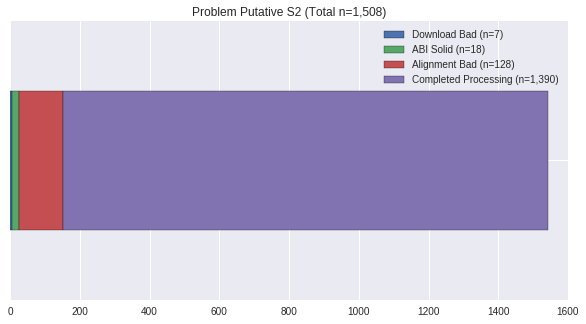

In [5]:
# Plot various flags from pre-alngnment pipeline
s2Flags = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': s2}, 
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr',
            'flag_download_bad': {
                '$cond': {
                    'if': {'$in': ['download_bad', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
            'flag_abi_solid': {
                '$cond': {
                    'if': {'$in': ['abi_solid', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
            'flag_alignment_bad': {
                '$cond': {
                    'if': {'$in': ['alignment_bad', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
            'flag_complete': {
                '$cond': {
                    'if': {'$in': ['complete', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
        }
    },
])))

s2Flags.set_index('srr', inplace=True)

_df = s2Flags.sum().sort_values().to_frame().T
fig, ax = plt.subplots(1,1, figsize=(10,5))
_df.plot.barh(stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
newLabels = []

mapper = {
    'flag_download_bad': 'Download Bad',
    'flag_abi_solid': 'ABI Solid',
    'flag_alignment_bad': 'Alignment Bad',
    'flag_complete': 'Completed Processing'
}

for l in labels:
    newLabels.append(mapper[l] + ' (n={:,})'.format(_df.ix[0, l]))
plt.legend(handles, newLabels)
ax.set_yticklabels([])
ax.set_title('Problem Putative S2 (Total n={:,})'.format(s2Flags.shape[0]));

## Determining Library Strategy

### Gene body coverage

Gene body coverage is a measure of how evenly the gene body is covered by the data. In RNA-seq we typically see a slight dip in coverage near the 5' and 3' ends and uniform coverage across the center.

In [6]:
# Get dataframe `hists` with histograms of genebody coverage and `metrics` with various metrics
# Grab picard RNA-seq metrics from database
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'}, 
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_workflow.picard_collectrnaseqmetrics': {'$exists': 1}}
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'flags': '$runs.pre_aln_flags',
            'metrics': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics'
        }
    },
])

_records = []
for record in agg:
    r = {}
    r['srx'] = record['srx']
    r['srr'] = record['srr']
    if 'SE' in record['flags']:
        r['strand'] = 'first'
    elif 'PE' in record['flags']:
        r['strand'] = 'second'
    else:
        r['strand'] = 'unstranded'
    
    for k, v in record['metrics'][r['strand']].items():
        r[k] = v
    _records.append(r)

metrics = pd.DataFrame(_records)
metrics.set_index(['srx', 'srr'], inplace=True)
metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS.replace('?', 0, inplace=True)
metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS.fillna(0, inplace=True)

# Import picard RNA-seq metrics histograms
_dfs = []
_mapper = {
    'first': 'FIRST_READ_TRANSCRIPTION_STRAND',
    'second': 'SECOND_READ_TRANSCRIPTION_STRAND',
    'unstranded': 'NONE'
}
for srx, srr, strand in metrics.reset_index()[['srx', 'srr', 'strand']].values:
    try:
        fname = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.{strand}.picard.collectrnaseqmetrics'.format(srx=srx, srr=srr, strand=_mapper[strand])
        pic =  parse_picardCollect_hist(srr, fname)
        if pic is None:
            raise FileNotFoundError
        _dfs.append(pic)
    except FileNotFoundError:
        print('Missing Files for: {}'.format(' -> '.join([srx, srr])))

hists = pd.concat(_dfs)

Missing Files for: SRX1951557 -> SRR3925163
Missing Files for: SRX999968 -> SRR1980989
Missing Files for: SRX999967 -> SRR1980988
Missing Files for: SRX657937 -> SRR1521302
Missing Files for: SRX367011 -> SRR1015574
Missing Files for: SRX029067 -> SRR069830
Missing Files for: SRX029066 -> SRR069829
Missing Files for: SRX017849 -> SRR038284
Missing Files for: SRX014801 -> SRR032096
Missing Files for: SRX014799 -> SRR032094
Missing Files for: SRX014798 -> SRR032093
Missing Files for: SRX012159 -> SRR029030
Missing Files for: SRX012158 -> SRR029029
Missing Files for: SRX012157 -> SRR029028
Missing Files for: SRX1598174 -> SRR3184775
Missing Files for: SRX1598173 -> SRR3184774
Missing Files for: SRX1364749 -> SRR2757173
Missing Files for: SRX1364748 -> SRR2757108


**NOTE: These 18 SRRs are missing the histogram from picard RNA-seq Metrics. I am not sure why because all the logs look good. Need to go back and run on a few of these and see if I can figure out why!!**

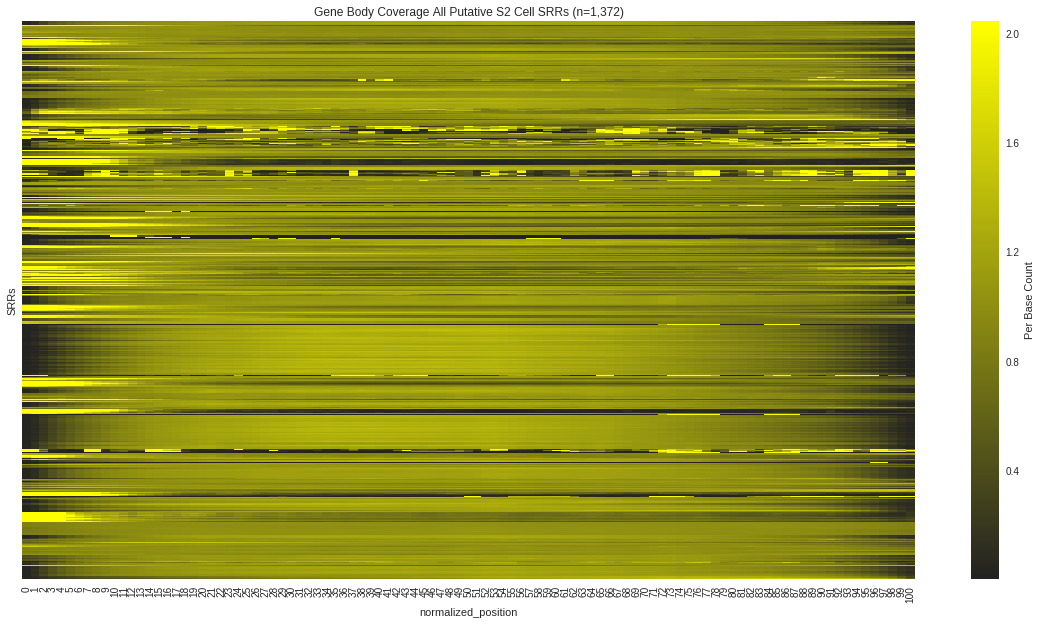

In [7]:
# Plot all data
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(hists, yticklabels=False, robust=True, cmap=sns.dark_palette('yellow', as_cmap=True), ax=ax, cbar_kws={'label': 'Per Base Count'});
ax.set_ylabel('SRRs')
ax.set_title('Gene Body Coverage All Putative S2 Cell SRRs (n={:,})'.format(hists.shape[0]));

### Picard RNA-seq metrics

Picard has a program call RNA-seq metrics which calculates a variety of summary statistics including:

* Percent Intergenic
* Median CV
* Median 5' to 3' Bias

The CV and 5' 3' bias will give us a different look at the gene body coverage, while the percent intergenic will give an idea of if reads are even mapped to intergenic regions suggesting a the sample is not RNA-seq.


In [8]:
# Create dataframe `dups` with markduplicate results
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'}, 
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_workflow.picard_markduplicates': {'$exists': 1}}
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'metrics': '$runs.pre_aln_workflow.picard_markduplicates'
        }
    },
])

_records = []
for record in agg:
    r = {}
    r['srx'] = record['srx']
    r['srr'] = record['srr']
    for k, v in record['metrics'].items():
        r[k] = v
    _records.append(r)

dups = pd.DataFrame(_records)
dups.set_index(['srx', 'srr'], inplace=True)

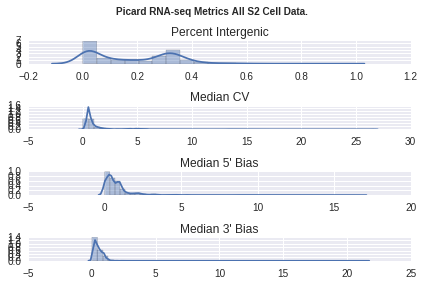

In [55]:
# plot various metrics
_metrics = metrics.copy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax1)
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax2)
sns.distplot(_metrics.MEDIAN_5PRIME_BIAS, ax=ax3)
sns.distplot(_metrics.MEDIAN_3PRIME_BIAS, ax=ax4)

ax1.set_title('Percent Intergenic')
ax1.set_xlabel('')
ax2.set_title('Median CV')
ax2.set_xlabel('')
ax3.set_title('Median 5\' Bias')
ax3.set_xlabel('')
ax4.set_title('Median 3\' Bias')
ax4.set_xlabel('')

plt.suptitle('Picard RNA-seq Metrics All S2 Cell Data.', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

### Junction Counts

In [63]:
# Create dataframe `featurecounts` with feature counts and junction counts from featurecounts
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'}, 
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_workflow.featurecounts': {'$exists': 1}}
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'junction_counts': '$runs.pre_aln_workflow.featurecounts.Assigned_Junction'
        }
    },
])

_jcount = pd.DataFrame(list(agg))
_jcount.set_index(['srx', 'srr'], inplace=True)

# Get other Junction features
_records = []
for srx, srr in _jcount.index.tolist():
    try:
        _features = parse_featureCounts_counts(srr, 
            '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts'.format(srx=srx, srr=srr))
        _junctions = parse_featureCounts_jcounts(srr, 
             '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts.jcounts'.format(srx=srx, srr=srr))
        _junctions['diff'] = np.abs(_junctions.Site1_location - _junctions.Site2_location)

        _filter = (
            (~_junctions.PrimaryGene.isnull()) &
            (_junctions.Site1_chr == _junctions.Site2_chr) &
            (_junctions['diff'] > 10) &
            (_junctions['diff'] < 300000) &
            (_junctions['count'] > 5)
        )

        _records.append({
            'srx': srx,
            'srr': srr,
            'num_junctions_covered': _junctions[_filter].shape[0],
            'num_features_covered': _features[_features > 10].shape[0],
        })
    except FileNotFoundError:
        print('Missing file: {srx} -> {srr}'.format(srx=srx, srr=srr))

_df = pd.DataFrame(_records).set_index(['srx', 'srr'])
featurecounts = _jcount.join(_df)

Missing file: SRX501034 -> SRR1204770
Missing file: SRX501033 -> SRR1204769
Missing file: SRX501031 -> SRR1204767
Missing file: SRX187086 -> SRR569914
Missing file: SRX187085 -> SRR569913


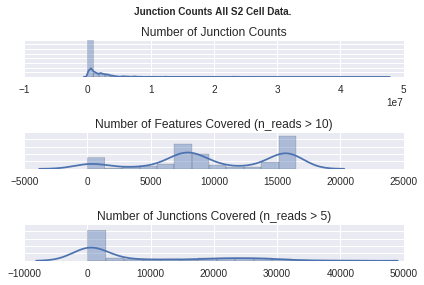

In [64]:
# plot number of reads spanning junctions all s2 data
fig, axes = plt.subplots(3, 1)
axes = axes.flatten()

_jcount = featurecounts
sns.distplot(_jcount.junction_counts, ax=axes[0])
axes[0].set_title('Number of Junction Counts')
axes[0].set_xlabel('')
axes[0].set_yticklabels([])

_jcount = featurecounts
sns.distplot(_jcount.num_features_covered.dropna(), ax=axes[1])
axes[1].set_title('Number of Features Covered (n_reads > 10)')
axes[1].set_xlabel('')
axes[1].set_yticklabels([])

_jcount = featurecounts
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=axes[2])
axes[2].set_title('Number of Junctions Covered (n_reads > 5)')
axes[2].set_xlabel('')
axes[2].set_yticklabels([])

plt.suptitle('Junction Counts All S2 Cell Data.', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

## Machine Learning with RNA-seq features

In [65]:
# Several lists `mRNA`, `chip`, `star`, `miRNA` with lists of samples that brian annotated
_bo = pd.read_excel('../../data/brian/20170428_s2cell_1243bo.xlsx', header=(0, 1))
_boFlags = _bo.loc[:, ('oliver', 'notes_and_flags')].dropna()

# Normalize Brian's flags 
mRNA_sample = _boFlags[_boFlags.str.lower().str.contains('mrna') | _boFlags.str.lower().str.contains('rnaseq')].index.tolist()
chip_sample = _boFlags[_boFlags.str.lower().str.contains('chip')].index.tolist()
star_sample = _boFlags[_boFlags.str.lower().str.contains('star')].index.tolist()
miRNA_sample = _boFlags[_boFlags.str.lower().str.contains('mirna')].index.tolist()

# Get the SRRs using BioSamples
def get_srr(samples):
    agg = remap.aggregate([
        {'$unwind': '$runs'},
        {
            '$match': {
                #'runs.pre_aln_flags': 'complete',
                #'runs.srr': {'$in': s2},
                'sample.biosample': {'$in': samples}      
            }
        },
        {
            '$project': {
                '_id': 0,
                'srr': '$runs.srr'
            }
        },
    ])

    return list(set([x['srr'] for x in agg]))

mRNA = get_srr(mRNA_sample)
chip = get_srr(chip_sample)
star = get_srr(star_sample)
miRNA = get_srr(miRNA_sample)

In [66]:
featurecounts.columns

Index(['junction_counts', 'num_features_covered', 'num_junctions_covered'], dtype='object')

In [145]:
# Format data for classifier

# Labels
Y = pd.DataFrame(index=hists.index, columns=['bo_annot'])
Y[Y.index.isin(mRNA)] = 0
Y[Y.index.isin(chip)] = 1
Y[Y.index.isin(star)] = 2
Y[Y.index.isin(miRNA)] = 3
Y.dropna(inplace=True)

# features
_metrics = metrics.copy()
_metrics.index = _metrics.index.droplevel(0)
_jcount = featurecounts.copy()
_jcount.index = _jcount.index.droplevel(0)
features = hists.join(_metrics[
    ['PCT_INTERGENIC_BASES', 'PCT_INTRONIC_BASES', 'MEDIAN_CV_COVERAGE', 
     'MEDIAN_5PRIME_BIAS', 'MEDIAN_3PRIME_BIAS']
]).join(_jcount)

features.dropna(inplace=True)
features.shape

(1367, 109)

In [146]:
features[features.index.isin(Y.index)].shape

(379, 109)

In [150]:
X = features[features.index.isin(Y.index)].values.astype(float)
Y = Y[Y.index.isin(features.index)].values.astype(float)

In [151]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=42)

In [152]:
# Set up scaler
scaler = preprocessing.StandardScaler().fit(X_train)

In [153]:
X_train_std = scaler.transform(X_train)

In [29]:
# Things that still need to be classified
UK = scaler.transform(features[~features.index.isin(Y.index.tolist())].values.astype(float))
UK_index = features[~features.index.isin(Y.index.tolist())].index.tolist()

# Make Y an array now
Y = Y.values.flatten().astype(int)

In [159]:
pd.DataFrame(X_train_std, columns=features.columns)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,PCT_INTERGENIC_BASES,PCT_INTRONIC_BASES,MEDIAN_CV_COVERAGE,MEDIAN_5PRIME_BIAS,MEDIAN_3PRIME_BIAS,junction_counts,num_features_covered,num_junctions_covered
0,-0.248588,-0.195374,-0.209823,-0.244629,-0.303352,-0.346790,-0.387255,-0.428056,-0.491604,-0.518663,-0.534026,-0.574188,-0.639583,-0.544084,-0.414077,-0.266582,-0.318983,-0.252699,-0.208757,-0.099528,0.053150,0.230359,0.152543,0.112965,0.171466,0.248680,0.317878,0.418554,0.447603,0.457851,0.478294,0.569558,0.570974,0.628057,0.011811,0.664446,0.633922,0.638885,0.669960,0.642382,0.576635,0.566371,0.566103,0.547640,0.575951,0.513997,0.530225,0.568913,0.545493,0.521105,0.510209,0.531380,0.583770,0.560212,0.548648,0.536775,0.489031,0.507165,0.527141,0.501903,0.501462,0.554244,0.438846,0.344081,0.342018,0.409515,0.458809,0.429792,0.383538,0.323813,0.272741,0.222323,0.206735,0.219425,0.232831,0.317545,0.267129,0.138558,0.017586,-0.161022,-0.162054,-0.129506,-0.197991,-0.184850,-0.084711,-0.153372,-0.321630,-0.471921,-0.568032,-0.546843,-0.521396,-0.510509,-0.520004,-0.594404,-0.540688,-0.401973,-0.100791,-0.100814,-0.160923,-0.157749,-0.291937,-0.455259,-0.499427,-0.221095,-0.179632,-0.099710,-0.713163,-0.620758,-0.754358
1,-0.251900,-0.198880,-0.217922,-0.231128,-0.222171,-0.188299,-0.160116,-0.141741,-0.118906,-0.102807,-0.096091,-0.022993,0.093096,0.190389,0.193325,0.140696,0.122094,0.075701,0.041222,0.049281,0.020452,0.009024,0.081712,0.070567,0.070246,0.083577,0.095997,0.127501,0.124461,0.098400,0.117779,0.143061,0.134082,0.139369,-0.049024,0.125417,0.122699,0.087699,0.054846,0.027773,0.023614,0.024704,0.013158,0.025100,0.033963,0.032883,0.035178,0.015110,0.006386,0.002521,0.027309,0.084635,0.085124,0.082693,0.080756,0.055348,0.029454,0.001374,0.018774,0.053051,0.081751,0.080337,0.080254,0.095014,0.085629,0.084223,0.147586,0.150390,0.149054,0.172117,0.170491,0.171679,0.140957,0.144437,0.202940,0.221197,0.233930,0.217302,0.261738,0.297444,0.321427,0.330880,0.345109,0.381486,0.379226,0.448268,0.521525,0.566738,0.588648,0.608994,0.608373,0.597522,0.541709,0.529848,0.501082,0.458120,-0.065708,-0.064459,0.133960,-0.052739,-0.220800,-0.446107,-0.393232,-0.341435,-0.142282,-0.022224,1.220002,0.033263,1.280305
2,-0.260167,-0.225868,-0.293695,-0.376683,-0.427444,-0.430924,-0.425797,-0.410513,-0.361716,-0.319577,-0.291650,-0.256153,-0.131985,0.032641,0.271788,0.450063,0.611556,0.820416,0.990712,1.049728,0.996892,0.928686,1.106636,1.091133,1.039067,0.969515,1.015317,1.009383,0.949874,0.994766,1.000990,0.890272,0.828260,0.783134,0.017153,0.776220,0.848236,0.828914,0.772941,0.718446,0.743670,0.727362,0.696342,0.684720,0.660813,0.698128,0.721922,0.766153,0.744340,0.722049,0.687276,0.684607,0.651651,0.691140,0.708218,0.707181,0.647146,0.614382,0.601746,0.642081,0.648623,0.609216,0.571939,0.505002,0.417132,0.294445,0.194875,0.153496,0.171988,0.219956,0.206089,0.124074,0.100740,0.069377,0.089997,-0.000988,-0.062839,-0.151918,-0.223615,-0.386795,-0.463026,-0.527680,-0.657266,-0.750842,-0.805040,-0.871438,-0.994875,-1.145990,-1.283349,-1.397036,-1.388520,-1.421850,-1.407040,-1.379208,-1.339096,-1.272393,-0.146772,-0.160944,-0.917480,-0.742545,-0.599684,-0.512323,-0.467796,-0.116900,-0.334858,-0.208784,0.134942,-0.146557,0.698959
3,0.373761,0.172359,0.210278,0.326081,0.372889,0.408265,0.477485,0.627398,0.631062,0.532812,0.631167,0.459417,0.321593,0.038835,-0.252721,-0.506730,-0.944856,-0.788743,-0.531817,-0.935886,-0.854190,-0.904960,-0.954935,-0.911015,-1.080309,-1.122956,-1.049380,-1.157509,-1.227116,-1.237356,-1.140373,-1.411621,-1.273517,-1.185066,-0.179216,-0.999631,-1.107574,-1.144101,-1.109392,-1.099627,-1.000039,-1.259654,-1.313157,-1.240260,-1.066687,-1.116175,-1.289070,-1.375553,-1.366324,-1.03

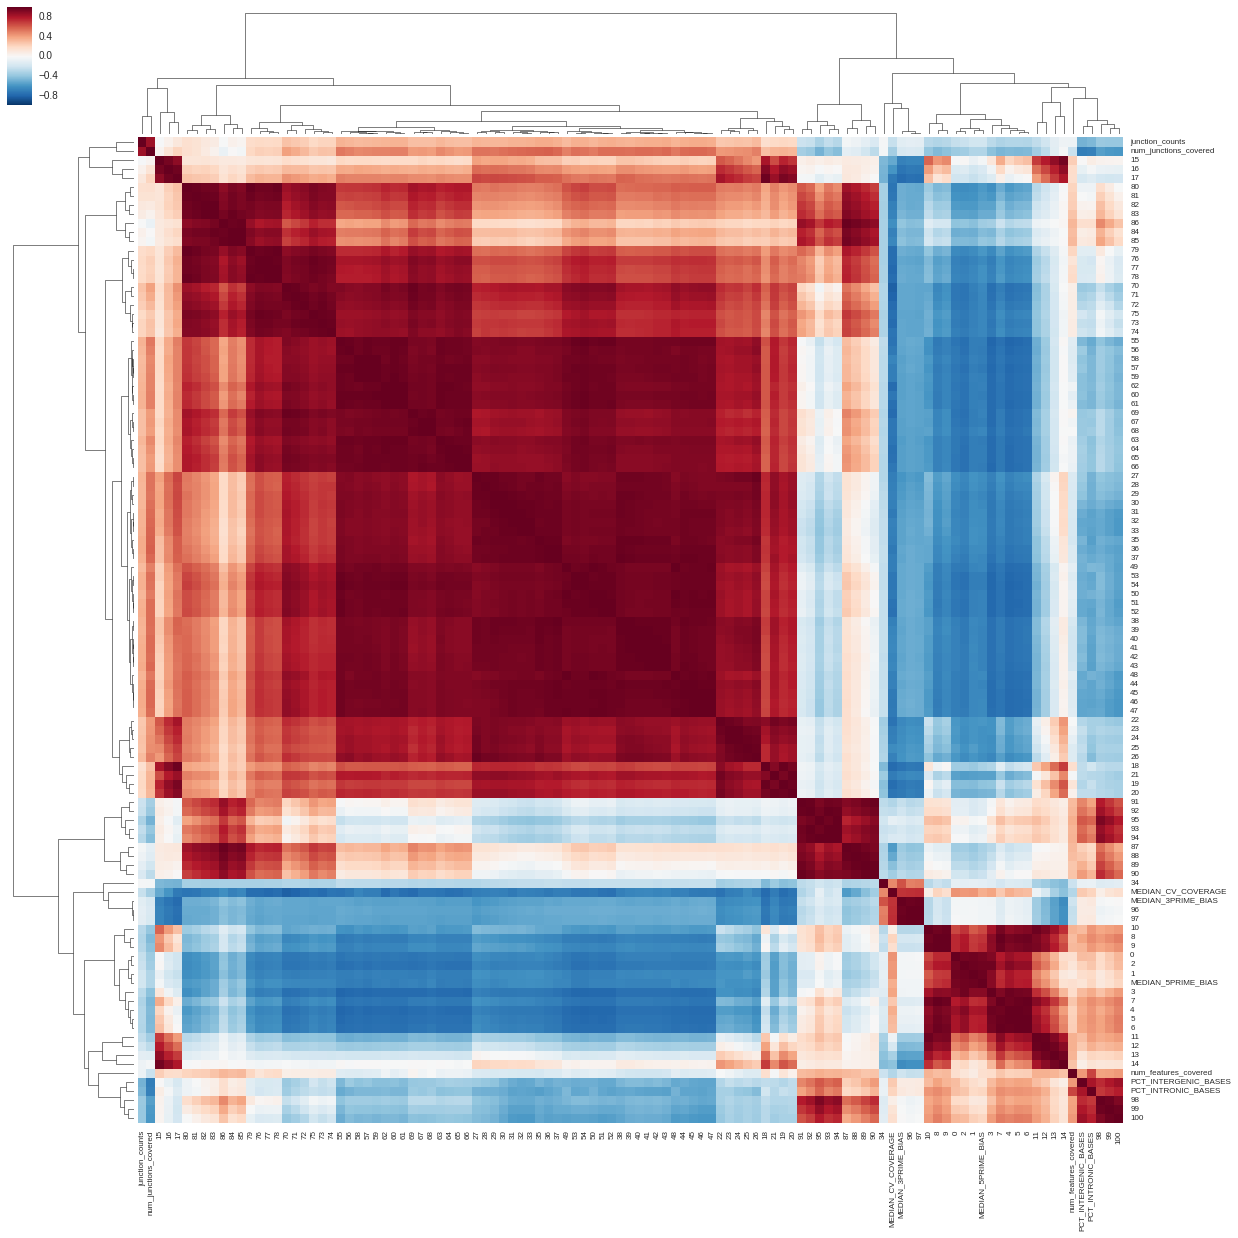

In [160]:
# Features have a lot of correlation structure
ax = sns.clustermap(pd.DataFrame(X_train_std, columns=features.columns).corr(), figsize=(20, 20))
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8);
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), rotation=90, fontsize=8);

In [30]:
# Run SVM classification
clf = svm.LinearSVC()
clf.fit(X, Y)
dec = clf.decision_function(UK)

# Pull out classes
# Positive values are the mostlikely class
classes = []
for row in dec > 0:
    classes.append(row.argmax())

# remap class names
_mapper = {
    0: 'mRNA',
    1: 'chip',
    2: 'star',
    3: 'miRNA'
}

classified = []
for k, v in zip(UK_index, classes):
    classified.append({'srr': k, 'class': _mapper[v]})

dfClasses = pd.DataFrame(classified).set_index('srr')

dfClasses['class'].unique()

array(['mRNA', 'chip', 'star', 'miRNA'], dtype=object)

##### Compare classification to NCBI metadata

Typically with these kind of classification I should have split the training set into 75% training and 25% testing. However, with such a small training dataset I did not want to split it at this point. Another option is to compare with metadata from the NCBI.SRA database. I don't completely trust this metadata -- which is why I am just not using their annotations to begin with -- but they should be mostly right.

The SRA database has additional classes ([here](http://sramongo.readthedocs.io/en/latest/sraConstants.html#library-strategy)) that I have not tried to separate, however it may be useful to see if these samples have some of these other classifiers. 

Ultimately it would be best to hand annotated additional samples and use them as a validation of the classifier.

In [50]:
# Combine NCBI Metadata classification with SVM classification

# Get list of SVM classified SRRs.
testClassSRR = dfClasses.index.tolist()

# Get NCBI annotation of library strategy
ncbiAnno = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': testClassSRR}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr',
            'strategy': '$sra.experiment.library_strategy',
        }
    },
])))

ncbiAnno.set_index('srr', inplace=True)
ncbiAnno.strategy.unique()

# Map SVM class labels to match NCBI labels.
dfClassesMapped = dfClasses.applymap(lambda x: {
    'mRNA': 'RNA-Seq', 
    'chip': 'ChIP-Seq', 
    'star': 'OTHER', 
    'miRNA': 'miRNA-Seq'}[x])

# Merge SVM class labels with NCBI labels
mergedClasses = dfClassesMapped.join(ncbiAnno, how='left')

# Look at differences between NCBI and classifier
pd.crosstab(mergedClasses['class'], mergedClasses['strategy'], margins=True)

strategy,ChIP-Seq,DNase-Hypersensitivity,MNase-Seq,OTHER,POOLCLONE,RIP-Seq,RNA-Seq,WGS,miRNA-Seq,All
class,,,,,,,,,,
ChIP-Seq,254,4,50,95,0,12,49,36,4,504
OTHER,0,0,0,17,0,1,2,0,9,29
RNA-Seq,111,3,18,75,4,38,201,0,5,455
miRNA-Seq,0,0,0,0,0,0,2,0,0,2
All,365,7,68,187,4,51,254,36,18,990


Unfortunately, there are large differences, however there are a few candidate samples that I can look at to get an idea on if the differences are NCBI mistakes or the classifier.

###### miRNA exploration

In [37]:
# Get list of miRNA SRRs and pull out BioSample to looking in biometa-app
_miRNA = dfClasses[dfClasses['class'] == 'miRNA'].index.tolist()

bs = [x['_id'] for x in biometa.find({'experiments.runs': {'$in': _miRNA}}, {'_id': 1})]

There are 2 SRRs that the classifier calls miRNA-Seq, but NCBI says are RNA-seq. This translate into the following BioSamples:

{{ ', '.join(bs) }}

Which corresponds to two BioProjects (PRJNA137667, PRJNA119663) submitted by the same authors (Perrimon group). Both Projects are shRNA knockdowns of *dpp* or *r2d2*. In the papers they state that these are actually small RNA libraries (19-24 nt).

###### ChIP Seq exploration

A quick look at samples that I classify as RNA-Seq that are ChIP-Seq in SRA is suggests that the classifier could use some work. The handful I looked at do seem like they are chip-seq.

The biggest problem with SRA metadata is human error. While something like the miRNA example above seems likely because perhaps the miRNA-seq category did not exists at the time. These kind of errors are probably less likely with ChIP-Seq. 

In [38]:
_chip = mergedClasses[(mergedClasses['class'] == 'RNA-Seq') & (mergedClasses['strategy'] == 'ChIP-Seq')].index.tolist()
bs = [x['_id'] for x in biometa.find({'experiments.runs': {'$in': _chip}}, {'_id': 1})]

print('There are {:,} SRRs that the classifier annotated '
      'as RNA-Seq that NCBI annotated as ChIP-Seq. '
      'This corresponds to {:,} BioSamples. '
      .format(len(_chip), len(bs))
     )

There are 111 SRRs that the classifier annotated as RNA-Seq that NCBI annotated as ChIP-Seq. This corresponds to 98 BioSamples. 
